<a href="https://colab.research.google.com/github/Droslj/scATAC-seq-complete-/blob/Google-colab/scATAC_seq_(1)_scVI_exec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

scATAC seq, based on scATAC seq processing Galaxy tutorials (scATAC preprocessing (2), Standard scATAC seq processing pipeline (1) )
AD Objects created in Galaxy using customized Galaxy WF with Snapatac2 and imported
(1) https://usegalaxy.eu/training-material/topics/single-cell/tutorials/scatac-preprocessing-tenx/tutorial.html#mapping-reads-to-a-reference-genome, (2) https://usegalaxy.eu/training-material/topics/single-cell/tutorials/scatac-standard-processing-snapatac2/tutorial.html
Data taken from the following NCBI study:
Metabolic adaptation pilots the differentiation of human hematopoietic cells (https://www.ncbi.nlm.nih.gov/bioproject/PRJNA1015713)
Import preprocessed Anndata object for four biological replicates, SRR26046013 (cells treated with AOA inhibitor), and SRR26046019 (untreated cells).
Following steps were performed in the preprocessing:
(1) Import matrices
(2) Compute fragment size distribution
(3) Compute TSS enrichment
(4) Filter cell counts based on TSSe
(5) Create cell by bin matrix based on 500 bp wide bins accross the whole genome
(6) Perform feature selection
(7) Perform Doublet removal
(8) Perform Dim reduction (spectral)
(9) Perform Clustering (neighborhood, UMAP, leiden)
(10) Create a cell by gene matrix
(11) Concatenate matrices using Inner join
(12) Remove batch effects

This file focuses on DA analysis using scvi package.

In [1]:
!pip install snapatac2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.2/687.2 kB 38.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 14.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account a

In [2]:
!pip install snapatac2 -q

In [3]:
!pip show snapatac2

Name: snapatac2
Version: 2.8.0
Summary: SnapATAC2: Single-cell epigenomics analysis pipeline
Home-page: https://github.com/
Author: Kai Zhang <kai@kzhang.org>
Author-email: Kai Zhang <zhangkai33@westlake.edu.cn>
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: anndata, igraph, kaleido, macs3, multiprocess, natsort, numpy, pandas, plotly, polars, pooch, pyarrow, pyfaidx, rustworkx, scikit-learn, scipy, tqdm, typeguard
Required-by: 


In [4]:
import snapatac2 as snap

In [5]:
!pip install umap-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 7.0 MB/s eta 0:00:00


In [6]:
import umap.umap_ as umap


In [7]:
from umap import UMAP

In [8]:
!pip install scanpy -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 8.7 MB/s eta 0:00:00


In [9]:
import scanpy as sc

In [10]:
!pip install harmonypy -q

In [11]:
import scanpy.external as sce

In [12]:
pip show scanpy

Name: scanpy
Version: 1.10.4
Summary: Single-Cell Analysis in Python.
Home-page: https://scanpy.org
Author: Alex Wolf, Philipp Angerer, Fidel Ramirez, Isaac Virshup, Sergei Rybakov, Gokcen Eraslan, Tom White, Malte Luecken, Davide Cittaro, Tobias Callies, Marius Lange, Andrés R. Muñoz-Rojas
Author-email: 
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: anndata, h5py, joblib, legacy-api-wrap, matplotlib, natsort, networkx, numba, numpy, packaging, pandas, patsy, pynndescent, scikit-learn, scipy, seaborn, session-info, statsmodels, tqdm, umap-learn
Required-by: 


In [13]:
!pip install tqdm -q

In [14]:
import numpy as np

In [15]:
import anndata as ad

In [16]:
import matplotlib.pyplot as plt

In [17]:
import seaborn as sns

In [18]:
import plotly.subplots as sp
import plotly.graph_objects as go

In [19]:
from scipy import stats

In [20]:
import pandas as pd

In [21]:
from tqdm.notebook import tqdm

In [22]:
!pip install --quiet scvi-tools

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.3/459.3 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.1/356.1 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 56.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all t

In [23]:
!pip install --quiet scvi-tools

In [42]:
!pip3 install leidenalg -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.3 MB/s eta 0:00:00


In [53]:
!pip install harmonypy -q  # Make sure harmonypy is installed

In [54]:
import scanpy.external as sce

In [24]:
import scvi

In [25]:
import os

In [26]:
import pooch

In [27]:
import scvi

In [28]:
import torch

# Import reads from google drive, preprocessed for scATAC-seq

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
adata = sc.read_h5ad('/content/drive/MyDrive/Colab Notebooks/AD_combined_scvi.h5ad')

# Preprocess AD object

In [31]:
# Filter out peaks that are rarely detected, to make the model train faster:
print("# regions before filtering:", adata.shape[-1])



# regions before filtering: 6062095


In [32]:
# compute the threshold: 5% of the cells
min_cells = int(adata.shape[0] * 0.05)


In [33]:
# in-place filtering of regions
sc.pp.filter_genes(adata, min_cells=min_cells)

print("# regions after filtering:", adata.shape[-1])

# regions after filtering: 77997


# Set up, train and save the model

In [34]:
scvi.model.PEAKVI.setup_anndata(adata)

In [35]:
model = scvi.model.PEAKVI(adata)
model.train()

<ipython-input-35-afe809d3088a>:2: DeprecationWarning: `save_best` is deprecated in v1.2 and will be removed in v1.3. Please use `enable_checkpointing` instead. See https://github.com/scverse/scvi-tools/issues/2568 for more details.
  model.train()
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.p

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 27974.711. Signaling Trainer to stop.


In [38]:
import os
import tempfile
import shutil

# Create a temporary directory if save_dir is not defined
save_dir = tempfile.TemporaryDirectory()

model_dir = os.path.join(save_dir.name, "peakvi_pbmc")
model.save(model_dir, overwrite=True)

# Copy the model directory to your Google Drive
drive_path = "/content/drive/MyDrive/Colab Notebooks/peakvi_pbmc"  # Choose your desired path
shutil.copytree(model_dir, drive_path)

# ... (rest of your code) ...

# Clean up the temporary directory
save_dir.cleanup()

print(f"Model saved to: {drive_path}")

Model saved to: /content/drive/MyDrive/Colab Notebooks/peakvi_pbmc


In [ ]:
#Load the model
#model = scvi.model.PEAKVI.load(model_dir, adata=adata)

In [39]:
model

PeakVI Model with params: 
n_hidden: 279, n_latent: 16, n_layers_encoder: 2, n_layers_decoder: 2 , dropout_rate: 0.1, 
latent_distribution: normal, deep injection: False, encode_covariates: False
Training status: Trained


# Visualizing and analyzing the latent space

In [40]:
PEAKVI_LATENT_KEY = "X_peakvi"

latent = model.get_latent_representation()
adata.obsm[PEAKVI_LATENT_KEY] = latent
latent.shape

(12007, 16)

In [43]:
PEAKVI_CLUSTERS_KEY = "clusters_peakvi"

# compute the k-nearest-neighbor graph that is used in both clustering and umap algorithms
sc.pp.neighbors(adata, use_rep=PEAKVI_LATENT_KEY, bat)
# compute the umap
sc.tl.umap(adata, min_dist=0.2)
# cluster the space (we use a lower resolution to get fewer clusters than the default)
sc.tl.leiden(adata, key_added=PEAKVI_CLUSTERS_KEY, resolution=0.2)

<ipython-input-43-cf39525b5c96>:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added=PEAKVI_CLUSTERS_KEY, resolution=0.2)


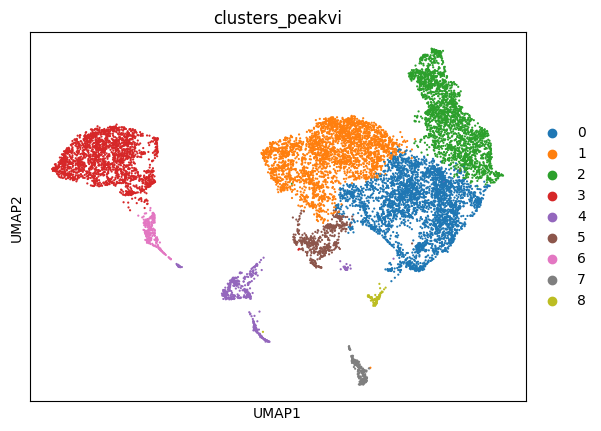

In [44]:
sc.pl.umap(adata, color=PEAKVI_CLUSTERS_KEY)

In [59]:
adata.obs

,n_fragment,frac_dup,frac_mito,tsse,Treatment,_scvi_batch,_scvi_labels,clusters_peakvi
index,,,,,,,,
AAACAACGAACGAGCA_1,23759,0.415605,0.000252,28.853238,Treated w/AOA,0,0,0
AAACAACGAAGAGGCT_1,15377,0.403037,0.002336,26.869046,Treated w/AOA,0,0,2
AAACAACGAAGTCGGA_1,19907,0.421316,0.001004,21.506626,Treated w/AOA,0,0,2
AAACAACGAGAAGGCT_1,16715,0.424926,0.000419,34.013027,Treated w/AOA,0,0,3
AAACAACGAGTACGTT_1,13361,0.510241,0.000449,23.785803,Treated w/AOA,0,0,0
...,...,...,...,...,...,...,...,...
TTTGGGATGAACGTAA_2,32519,0.331308,0.001811,17.173341,Untreated,0,0,1
TTTGGGATGAAGTCTC_2,24623,0.296449,0.000081,16.473318,Untreated,0,0,0
TTTGGGATGATGTGGG_2,27001,0.322902,0.000814,18.357488,Untreated,0,0,0


# Differential accessibility

In [47]:
# Get the unique cluster names
cluster_names = adata.obs[PEAKVI_CLUSTERS_KEY].unique()
print(cluster_names)

['0', '2', '3', '4', '6', '5', '1', '7', '8']
Categories (9, object): ['0', '1', '2', '3', ..., '5', '6', '7', '8']


In [64]:
# Choose the actual cluster names for group1 and group2
# For example, if your clusters are labeled '0', '1', '2', etc., you might use:
da_res11 = model.differential_accessibility(
    groupby=PEAKVI_CLUSTERS_KEY,
    group1=cluster_names[0],  # Replace with actual cluster name
    group2=cluster_names[1],  # Replace with actual cluster name
    two_sided=True,
    batch_correction=True
)

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

In [65]:
da_res11

,prob_da,is_da_fdr,bayes_factor,effect_size,emp_effect,est_prob1,est_prob2,emp_prob1,emp_prob2
chr10:49272500-49273000,0.9922,True,4.845800,-0.455461,-0.208863,0.666571,0.211110,0.310037,0.101174
chr17:73474500-73475000,0.9912,True,4.724163,0.580822,0.261235,0.203390,0.784211,0.101909,0.363144
chr3:128585000-128585500,0.9900,True,4.595119,0.600889,0.284390,0.160420,0.761309,0.089594,0.373984
chr2:69799000-69799500,0.9892,True,4.517349,0.637047,0.366357,0.235025,0.872072,0.127771,0.494128
chr1:164712000-164712500,0.9892,True,4.517349,0.711272,0.412998,0.190804,0.902076,0.108682,0.521680
...,...,...,...,...,...,...,...,...,...
chr17:4967000-4967500,0.0000,False,-18.420681,-0.000221,0.006961,0.999557,0.999335,0.587438,0.594399
chr17:4967500-4968000,0.0000,False,-18.420681,-0.000921,0.002835,0.998829,0.997908,0.590209,0.593044
chr10:1049000-1049500,0.0000,False,-18.420681,-0.000262,-0.035657,0.999526,0.999263,0.683805,0.648148
chr17:4710000-4710500,0.0000,False,-18.420681,-0.001546,-0.021662,0.998782,0.997237,0.574507,0.552846
